Importing the required libraries and constants

In [1]:
import os, pathlib, json, numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import f1_score

SEED = 42
IMG_SIZE = (224, 224)
BATCH = 32

ROOT_DIR = pathlib.Path("data/")
TRAIN_DIR = ROOT_DIR / "training"
VAL_DIR   = ROOT_DIR / "validation"
TEST_DIR  = ROOT_DIR / "testing"

TRAIN_SPLIT = 0.8
VAL_SPLIT   = 0.1
TEST_SPLIT  = 0.1

MODEL_DIR = "models"

Distribute the images to create training, validation and testing sets

In [2]:
# import shutil
# from collections import defaultdict

# np.random.seed(SEED )
# # Gather all images by class from all splits
# all_images = defaultdict(list)
# for split_dir in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
#     for class_dir in split_dir.iterdir():
#         if class_dir.is_dir():
#             for img_file in class_dir.glob("*.jpg"):
#                 all_images[class_dir.name].append(img_file)
#             for img_file in class_dir.glob("*.png"):
#                 all_images[class_dir.name].append(img_file)
#             for img_file in class_dir.glob("*.jpeg"):
#                 all_images[class_dir.name].append(img_file)

# # Redistribute according to split ratios
# for class_name, img_files in all_images.items():
#     img_files = np.array(img_files)
#     np.random.shuffle(img_files)
#     n_total = len(img_files)
#     n_train = int(n_total * TRAIN_SPLIT)
#     n_val = int(n_total * VAL_SPLIT)
#     n_test = n_total - n_train - n_val

#     splits = [
#         (TRAIN_DIR / class_name, img_files[:n_train]),
#         (VAL_DIR / class_name, img_files[n_train:n_train+n_val]),
#         (TEST_DIR / class_name, img_files[n_train+n_val:]),
#     ]

#     for target_dir, files in splits:
#         target_dir.mkdir(parents=True, exist_ok=True)
#         for f in files:
#             dest = target_dir / f.name
#             if f.resolve() != dest.resolve():
#                 shutil.move(str(f), str(dest))

# print("Data redistribution complete.")
# # Print out number of images in each split for each class
# for class_name in all_images.keys():
#     train_count = len(list((TRAIN_DIR / class_name).glob("*.jpg"))) + len(list((TRAIN_DIR / class_name).glob("*.png"))) + len(list((TRAIN_DIR / class_name).glob("*.jpeg")))
#     val_count = len(list((VAL_DIR / class_name).glob("*.jpg"))) + len(list((VAL_DIR / class_name).glob("*.png"))) + len(list((VAL_DIR / class_name).glob("*.jpeg")))
#     test_count = len(list((TEST_DIR / class_name).glob("*.jpg"))) + len(list((TEST_DIR / class_name).glob("*.png"))) + len(list((TEST_DIR / class_name).glob("*.jpeg")))
#     print(f"Class '{class_name}': Training={train_count}, Validation={val_count}, Testing={test_count}")

This file is for training the various image classification models

In [3]:
import tensorflow as tf
from tensorflow import keras

# Build datasets WITHOUT validation_split
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=False   # keep order stable for metrics/plots
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=False   # keep order stable for metrics/plots
)

# Class names (e.g., ['01-minor','02-moderate','03-severe'])
class_names = train_ds.class_names
NUM_CLASSES = len(class_names)
print("Classes:", class_names)

# (Optional) pretty labels for display, stripping the numeric prefixes
pretty_names = [c.split('-', 1)[-1] if '-' in c else c for c in class_names]

AUTOTUNE = tf.data.AUTOTUNE
def configure(ds, training=False):
    ds = ds.cache()
    if training:
        ds = ds.shuffle(1024, seed=SEED)
    return ds.prefetch(AUTOTUNE)

train_ds = configure(train_ds, training=True)
val_ds   = configure(val_ds)
test_ds  = configure(test_ds)

Found 2035 files belonging to 4 classes.
Found 253 files belonging to 4 classes.
Found 258 files belonging to 4 classes.
Classes: ['00-none', '01-minor', '02-moderate', '03-severe']


Setting up F1 function for performance evaluation

In [4]:
import numpy as np
from sklearn.metrics import f1_score

class MacroF1Callback(keras.callbacks.Callback):
    def __init__(self, val_ds, num_classes):
        super().__init__()
        self.val_ds = val_ds
        self.num_classes = num_classes

    def on_epoch_end(self, epoch, logs=None):
        y_true = []
        y_pred = []
        for xb, yb in self.val_ds:
            probs = self.model.predict(xb, verbose=0)
            y_pred.extend(np.argmax(probs, axis=1))
            # yb may be ints or one-hot depending on your pipeline:
            if yb.ndim == 2:  # one-hot
                y_true.extend(np.argmax(yb.numpy(), axis=1))
            else:             # integer labels
                y_true.extend(yb.numpy())
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        macro_f1 = f1_score(y_true, y_pred, average="macro")
        logs = logs or {}
        logs["val_macro_f1"] = macro_f1
        print(f"\nval_macro_f1: {macro_f1:.4f}")

In [5]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="augment")

preprocess = keras.applications.resnet50.preprocess_input

base = keras.applications.resnet50.ResNet50(
    include_top=False, weights="imagenet", input_shape=(*IMG_SIZE, 3)
)
base.trainable = False

inputs = keras.Input(shape=(*IMG_SIZE, 3))
x = data_augmentation(inputs)
x = preprocess(x)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ augment             │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ augment[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ augment[0][0]     │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ augment[0][0]     │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 4)         │      8,196 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

# 5. Training with Checkpoint

Early stopping with checkpoint. we start with frozen and then unlock the model. GPU enabled runtime will run much faster. If you plot the curves what can it tell you on the epochs?

In [6]:
EPOCHS_FROZEN = 30
EPOCHS_FINE   = 60

model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
    metrics=[keras.metrics.CategoricalAccuracy(name="acc")]
)

# If your datasets are integer labels, map to one-hot for this loss:
train_oh = train_ds.map(lambda x, y: (x, tf.one_hot(y, NUM_CLASSES)))
val_oh   = val_ds.map(lambda x, y: (x, tf.one_hot(y, NUM_CLASSES)))

f1_cb = MacroF1Callback(val_ds, NUM_CLASSES)

#Model filename
filename = MODEL_DIR + "\\resnet_frozen.keras"

ckpt1 = keras.callbacks.ModelCheckpoint(
    filename, monitor="val_macro_f1", mode="max",
    save_best_only=True, verbose=1
)
early = keras.callbacks.EarlyStopping(monitor="val_macro_f1", mode="max",
                                      patience=5, restore_best_weights=True)
reduce = keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                           factor=0.5, patience=2, verbose=1)

hist1 = model.fit(
    train_oh, validation_data=val_oh,
    epochs=EPOCHS_FROZEN, callbacks=[f1_cb, ckpt1, early, reduce], verbose=2
)

Epoch 1/30

val_macro_f1: 0.5287

Epoch 1: val_macro_f1 improved from None to 0.52874, saving model to models\resnet_frozen.keras
64/64 - 74s - 1s/step - acc: 0.3720 - loss: 1.4506 - val_acc: 0.5375 - val_loss: 1.0797 - val_macro_f1: 0.5287 - learning_rate: 3.0000e-04
Epoch 2/30

val_macro_f1: 0.5965

Epoch 2: val_macro_f1 improved from 0.52874 to 0.59647, saving model to models\resnet_frozen.keras
64/64 - 61s - 957ms/step - acc: 0.5258 - loss: 1.1557 - val_acc: 0.6047 - val_loss: 0.9897 - val_macro_f1: 0.5965 - learning_rate: 3.0000e-04
Epoch 3/30

val_macro_f1: 0.6177

Epoch 3: val_macro_f1 improved from 0.59647 to 0.61769, saving model to models\resnet_frozen.keras
64/64 - 60s - 944ms/step - acc: 0.5774 - loss: 1.0366 - val_acc: 0.6324 - val_loss: 0.9259 - val_macro_f1: 0.6177 - learning_rate: 3.0000e-04
Epoch 4/30

val_macro_f1: 0.6286

Epoch 4: val_macro_f1 improved from 0.61769 to 0.62860, saving model to models\resnet_frozen.keras
64/64 - 60s - 936ms/step - acc: 0.6147 - loss: 0

6. Unfreeze (Fine Tuning)

In [7]:
# Unfreeze top layers except BatchNorm
for layer in base.layers[-60:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
    metrics=[keras.metrics.CategoricalAccuracy(name="acc")]
)

filename = MODEL_DIR + "\\resnet_finetuned.keras"
f1_cb2 = MacroF1Callback(val_ds, NUM_CLASSES)
ckpt2 = keras.callbacks.ModelCheckpoint(
    filename, monitor="val_macro_f1", mode="max",
    save_best_only=True, verbose=1
)

hist2 = model.fit(
    train_oh, validation_data=val_oh,
    epochs=EPOCHS_FINE, callbacks=[f1_cb2, ckpt2, early, reduce], verbose=2
)

Epoch 1/60

val_macro_f1: 0.6731

Epoch 1: val_macro_f1 improved from None to 0.67311, saving model to models\resnet_finetuned.keras
64/64 - 104s - 2s/step - acc: 0.6722 - loss: 0.8557 - val_acc: 0.6759 - val_loss: 0.8277 - val_macro_f1: 0.6731 - learning_rate: 1.0000e-05
Epoch 2/60

val_macro_f1: 0.6672

Epoch 2: val_macro_f1 did not improve from 0.67311
64/64 - 84s - 1s/step - acc: 0.6948 - loss: 0.8049 - val_acc: 0.6798 - val_loss: 0.8168 - val_macro_f1: 0.6672 - learning_rate: 1.0000e-05
Epoch 3/60

val_macro_f1: 0.6567

Epoch 3: val_macro_f1 did not improve from 0.67311
64/64 - 84s - 1s/step - acc: 0.7322 - loss: 0.7506 - val_acc: 0.6601 - val_loss: 0.8321 - val_macro_f1: 0.6567 - learning_rate: 1.0000e-05
Epoch 4/60

val_macro_f1: 0.6845

Epoch 4: val_macro_f1 improved from 0.67311 to 0.68451, saving model to models\resnet_finetuned.keras
64/64 - 86s - 1s/step - acc: 0.7627 - loss: 0.7056 - val_acc: 0.6877 - val_loss: 0.7980 - val_macro_f1: 0.6845 - learning_rate: 1.0000e-05
Epoc

7. Performance Evaluation
there are also other things to show. can you think of any?

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
MODEL_FILE = MODEL_DIR + "\\resnet_finetuned.keras"

best = keras.models.load_model(MODEL_FILE, compile=False)
best.compile(optimizer=keras.optimizers.Adam(1e-5),
             loss=keras.losses.CategoricalCrossentropy(),
             metrics=["accuracy"])

y_true, y_pred = [], []
for xb, yb in test_ds:
    probs = best.predict(xb, verbose=0)
    y_pred.extend(np.argmax(probs, axis=1))
    if yb.ndim == 2: y_true.extend(np.argmax(yb.numpy(), axis=1))
    else:            y_true.extend(yb.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=class_names))
print("Macro-F1:", f1_score(y_true, y_pred, average="macro"))


Confusion matrix:
 [[62  4  4  1]
 [ 3 41  5  1]
 [ 7 14 31 15]
 [ 2  4 15 49]]

Classification report:
              precision    recall  f1-score   support

     00-none       0.84      0.87      0.86        71
    01-minor       0.65      0.82      0.73        50
 02-moderate       0.56      0.46      0.51        67
   03-severe       0.74      0.70      0.72        70

    accuracy                           0.71       258
   macro avg       0.70      0.71      0.70       258
weighted avg       0.70      0.71      0.70       258

Macro-F1: 0.702405271803214


Found 7626 files belonging to 6 classes.
Using 762 files for validation.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step


IndexError: list index out of range

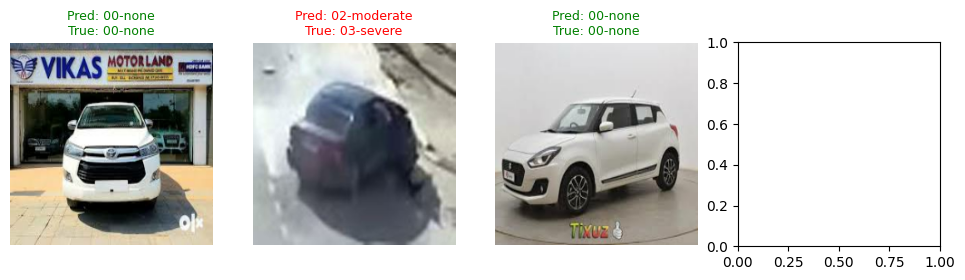

In [9]:
import matplotlib.pyplot as plt
import random
MODEL_FILE = MODEL_DIR + "\\resnet_finetuned.keras"

# Create a dataset with raw images and labels (no one-hot)
val_raw = tf.keras.utils.image_dataset_from_directory(
    ROOT_DIR,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH,
    validation_split=0.1,
    subset="validation",
    shuffle=True
)

# Get a small batch
images, labels = next(iter(val_raw))
pred_probs = best.predict(images)
pred_ids = np.argmax(pred_probs, axis=1)
true_ids = labels.numpy()

# Plot 12 random samples
plt.figure(figsize=(12, 9))
for i, idx in enumerate(random.sample(range(len(images)), 12)):
    ax = plt.subplot(3, 4, i + 1)
    img = images[idx].numpy().astype("uint8")
    true_label = class_names[true_ids[idx]]
    pred_label = class_names[pred_ids[idx]]
    color = "green" if pred_label == true_label else "red"
    plt.imshow(img)
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color, fontsize=9)
    plt.axis("off")
plt.tight_layout()
plt.show()